# Importations

In [2]:
import pandas as pd
from math import *
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import dateutil.parser
import re
import contextualbandits
import time
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from scipy import stats as stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
import statsmodels.api as sm

pd.set_option('display.max_columns', 80)
pd.set_option('expand_frame_repr', True)

%matplotlib inline
sns.set_palette("hls")

# Fonctions

#### ControlDataMissing :

Control data for bandit. Check in a dataframe if there is some missing values Print a message if it's not respected. Else return TRUE.



Arguments :

- visitor_reward : Dataframe of integers or numeric values



Value :

- Logical value

In [1]:
def ControlDataMissing(visitor_reward):
    t = pd.DataFrame.isnull(visitor_reward)
    c = sum(pd.DataFrame.sum(t))
    
    if c > 0 :
        raise ValueError('Missing data in arm results database')

#### DataControlK :

Control arm and data for bandit Check if a dataframe gets an equal number of colonms than K possible arms. Check if K geq 2. Print a message and stop if this two conditions are not respected. Else return TRUE.



Arguments :

- visitor_reward : Dataframe of integer or numeric values

- K : Integer value (optional)



Value :

- Logical value

In [12]:
def DataControlK(visitor_reward, K = None):
    if K == None :
        K = np.shape(visitor_reward)[1]
    
    if K < 2 :
        raise ValueError('Arm must be superior or equal to 2')
    
    if np.shape(visitor_reward)[1] != K :
        raise ValueError('Each arm need a result')

#### PlayArm :

The variable arm represents the selected arm visitor_reward is a dataframe of rewards iter is the current iteration S is the matrix of results for each arm (tests and empirical mean) In the matrix S :

Retrieves the reward associated with the iter instant in the reward dataframe

- Updates the average reward of the chosen arm with the reward obtained

- Adds a test to the selected arm (arm)

- Returns the updated S matrix



Arguments :

- iter : Integer value

- arm : Integer value

- S : Array

- visitor_reward : Array



Value :

- S : Array

In [42]:
def PlayArm(iter,arm,S,visitor_reward):

    arm = int(arm)
    iter = int(iter)
    S[0,arm] = (S[0,arm]*S[1,arm] + visitor_reward[iter,arm]) / (S[1,arm]+1)
    #play
    S[1,arm] += 1
    return S

#### BanditRewardControl :

Control data for bandit algorithm. See also ControlDataMissing and DataControlK



Arguments :

- visitor_reward : Dataframe of integer or numeric values

- K : Integer value (optional)



Value :

- Logical value

In [43]:
def BanditRewardControl(visitor_reward,K = None):
    if K == None :
        K = visitor_reward.shape[1]
        DataControlK(visitor_reward,K)
        ControlDataMissing(visitor_reward)

#### UniformBandit :

Control data in visitor_reward with BanditRewardControl Stop if something is wrong. Generate a matrix to save the results (S).

At each iteration :

- Choose alternatively an arm

- Receives a reward in visitor_reward for the arm and associated iteration

- Updates the results matrix S.



Arguments :

- visitor_reward : Dataframe of integer or numeric values

- K : Integer value (optional)



Values :

List of element:

- S:numerical matrix of results ,

- choice: choices of the algorithm,

- time: time of cumputation,

In [53]:
def UniformBandit(visitor_reward, K = None):
    
    if K == None :
        K = visitor_reward.shape[1]
    
    # control :
    BanditRewardControl(visitor_reward,K)
    
    # data formating :
    visitor_reward = np.array(visitor_reward)
    
    # keep list of choices :
    n = np.shape(visitor_reward)[0]
    choice = np.zeros(n)
    S = np.zeros((2,K))
    
    tic = time.time()
    
    if K > n :
        print("Warning : more arm than visitor")
        
        for j in range(n):
            S = PlayArm(j,j,S)
        choice = np.arange(1,n+1,1)
        toc = tme.time()
        return [S,choice,toc-tic]
    
    else :
        
        for i in range(n):
            choice[i] = ((i+1)%K)
            S = PlayArm(i,i%K, S, visitor_reward)
        toc = time.time()
        
        return [S,choice,toc-tic]

#### Regret :

See "cumulative_regret.ipynb"

In [54]:
def SimpleRegret(choice,visitor_reward):
    visitor_reward
    n = visitor_reward.shape[0]
    regret = np.zeros(n)
    for i in range(n):
        regret[i] = RegretValue(choice[i],np.array(visitor_reward)[i,:])
    return regret

def RegretValue(arm, vec_visitor_reward):
    return max(vec_visitor_reward) - vec_visitor_reward[int(arm)]

def cumulativeRegret(choice,visitor_reward):
    regret = SimpleRegret(choice,visitor_reward)
    plt.plot(np.cumsum(regret));
    plt.xlabel('Time T');
    plt.ylabel('Cumulative regret'); 
    return np.cumsum(regret)

# Tests :

#### Tests sur données générées :

Génération d'un problème de bandits avec 5 bras différents : V1,V2,V3,V4,V5; puis test de l'algo UniformBandit sur celui-ci (avec tracé du regret).

In [55]:
V1 = np.random.binomial(1,0.6,5000)
V2 = np.random.binomial(1,0.7,5000)
V3 = np.random.binomial(1,0.5,5000)
V4 = np.random.binomial(1,0.3,5000)
V5 = np.random.binomial(1,0.9,5000)

a = np.transpose(np.array([V1,V2,V3,V4,V5]))

rewards = pd.DataFrame(a, columns = ['Bandit 1', 'Bandit 2', 'Bandit 3', 'Bandit 4', 'Bandit 5'])

In [56]:
random_alloc = UniformBandit(visitor_reward)

Tracé du regret cumulé :

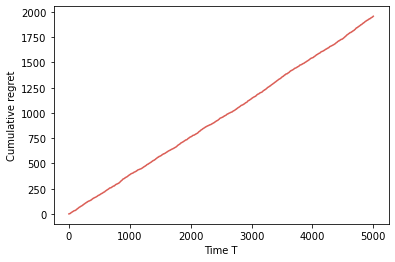

In [57]:
cum_reg_rand = cumulativeRegret(random_alloc[1],rewards)